In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

In [2]:
class Solution:
	def __init__(self, dimension, lower_bound, upper_bound):
		self.dimension = dimension
		self.lB = lower_bound  # we will use the same bounds for all parameters
		self.uB = upper_bound
		self.parameters = np.zeros(self.dimension) #solution parameters
		self.f = np.inf  # objective function evaluation

In [3]:
class Function:
    def __init__(self, name):
        self.name = name
        
    def sphere(self, params):
        sum = 0
        for p in params:
            sum += p**2
        return sum
    
    def ackley(self, params, a=20.0, b=0.2, c=2*np.pi):
        x = np.asarray(params, dtype=float)
        d = x.size
        term1 = -a * np.exp(-b * np.sqrt(np.sum(x**2) / d))
        term2 = -np.exp(np.sum(np.cos(c * x)) / d)
        return term1 + term2 + a + np.e
    
    def rastrigin(self, params):
        d = len(params)   # dimenze
        total = 0
        for p in params:
            total += (p**2 - 10 * np.cos(2 * np.pi * p))
        return 10 * d + total
    
    def rosenbrock(self, params):
        total = 0
        d = len(params)
        for i in range(d - 1):
            total += 100 * (params[i+1] - params[i]**2)**2 + (params[i] - 1)**2
        return total
    
    def griewank(self, params):
        x = np.asarray(params, dtype=float)
        d = len(x)
        
        # první část: součet x_i^2 / 4000
        sum_term = np.sum(x**2) / 4000.0
        
        # druhá část: součin cos(x_i / sqrt(i))
        prod_term = 1.0
        for i in range(d):
            prod_term *= np.cos(x[i] / np.sqrt(i + 1))  # i+1 protože Python indexuje od 0
        
        return sum_term - prod_term + 1
    
    def schwefel(self, params):
        x = np.asarray(params, dtype=float)
        d = x.size
        return 418.9829 * d - np.sum(x * np.sin(np.sqrt(np.abs(x))))
    
    def levy(self, params):
        x = np.asarray(params, dtype=float)
        w = 1 + (x - 1.0)/4.0
        d = w.size

        term1 = np.sin(np.pi * w[0])**2
        term2 = 0.0 if d < 2 else np.sum((w[:-1] - 1.0)**2 * (1.0 + 10.0 * np.sin(np.pi*w[:-1] + 1.0)**2))
        term3 = (w[-1] - 1.0)**2 * (1.0 + np.sin(2.0*np.pi*w[-1])**2)

        return float(term1 + term2 + term3)
    
    def michalewicz(self, params, m=10):
        x = np.asarray(params, dtype=float)
        s = 0.0
        for i, xi in enumerate(x, start=1):          # i = 1..d
            s += np.sin(xi) * (np.sin(i * xi**2 / np.pi) ** (2 * m))
        return -float(s)
    
    
    def zakharov(self, params):
        x = np.asarray(params, dtype=float)
        d = len(x)
        
        term1 = np.sum(x**2)
        term2 = np.sum(0.5 * (np.arange(1, d+1)) * x)
        
        return float(term1 + term2**2 + term2**4)



In [4]:
def animation(X, Y, Z, name, history, cmap_type="coolwarm", interval_ms=500, repeat=False):
    hx = np.array([float(p[0][0]) for p in history], dtype=float)
    hy = np.array([float(p[0][1]) for p in history], dtype=float)
    hz = np.array([float(p[1])    for p in history], dtype=float)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(X, Y, Z, cmap=cmap_type, alpha=0.35, zorder=0)
    ax.set_title(name)
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("f(x,y)")


    # --- jenom jeden bod ---
    point, = ax.plot([hx[0]], [hy[0]], [hz[0]],
                     marker="o", markersize=8,
                     color="black", linestyle="None",
                     zorder=10)

    def update(i):
        point.set_data([hx[i]], [hy[i]])
        point.set_3d_properties([hz[i]])
        return point,

    ani = FuncAnimation(fig, update, frames=len(history),
                        interval=interval_ms, blit=False, repeat=repeat)

    plt.show()
    return ani


In [38]:
def simulated_annealing(function, dimension, lower_bound, upper_bound,  T_0, T_min, alpha, sigma=0.1, seed=None):
    rng = np.random.default_rng(seed)
    best_solution = Solution(dimension, lower_bound, upper_bound)
    best_solution.parameters = rng.uniform(lower_bound, upper_bound, size=dimension)
    best_solution.f = function(best_solution.parameters)
    history = []
    T=T_0
    
    while T>T_min:
        #print(f'T je {T}')
        current_parameters = [	normal_in_bounds(rng, p, sigma, lower_bound, upper_bound) for  p in best_solution.parameters]
        current_f = function(current_parameters)
            
        if best_solution.f > current_f:
            best_solution.parameters = current_parameters
            best_solution.f = current_f
            history.append((current_parameters,current_f) )
        else:
            r = rng.random()
            #if r < np.e**(-(current_f-best_solution.f)/T):
            #print(f'R je {r} a vypočet je {np.exp(-(current_f-best_solution.f)/T)}')
            if r<np.exp(-(current_f-best_solution.f)/T):
                #print("Prošlo")
                best_solution.parameters = current_parameters
                best_solution.f = current_f
                history.append((current_parameters,current_f) )

        T=T*alpha
        
    return best_solution, history

def normal_in_bounds(rng, mean, sigma, low, high):
    val = rng.normal(mean, sigma)
    while val < low or val > high:
        val = rng.normal(mean, sigma)
    return val


In [49]:
def simulated_annealing(function, dimension, lower_bound, upper_bound,
                        T_0, T_min, alpha, sigma=0.1, seed=None):
    rng = np.random.default_rng(seed)

    # inicializace aktuálního řešení
    current = Solution(dimension, lower_bound, upper_bound)
    current.parameters = rng.uniform(lower_bound, upper_bound, size=dimension)
    current.f = function(current.parameters)

    # nejlepší řešení
    best = Solution(dimension, lower_bound, upper_bound)
    best.parameters = current.parameters.copy()
    best.f = current.f

    history = [(current.parameters.copy(), current.f, T_0)]
    T = T_0

    while T > T_min:
        # adaptivní sigma – postupně se zmenšuje s teplotou
        sigma_current = sigma * (T / T_0)

        # vytvoření souseda
        new_params = np.array([
            normal_in_bounds(rng, p, sigma_current, lower_bound, upper_bound)
            for p in current.parameters
        ])
        f_new = function(new_params)

        delta = f_new - current.f

        # rozhodnutí o přijetí
        if delta < 0 or rng.random() < np.exp(-delta / T):
            current.parameters = new_params
            current.f = f_new

            # případná aktualizace nejlepšího řešení
            if current.f < best.f:
                best.parameters = current.parameters.copy()
                best.f = current.f

        history.append((current.parameters.copy(), current.f, T))
        T *= alpha

    return best, history

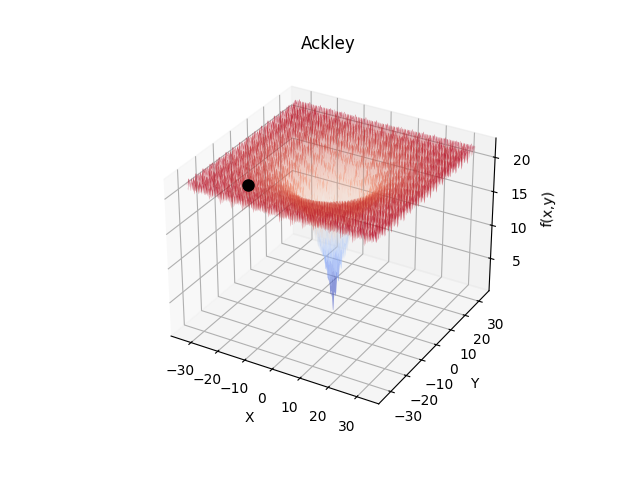

In [84]:
f_ackley =  Function("Ackley")

x = np.linspace(-32.768, 32.768, 500)   # body na ose X
y = np.linspace(-32.768, 32.768, 500)   # body na ose Y

points = np.array([[i, j] for i in x for j in y])

Z = np.array([f_ackley.ackley(p) for p in points])

Z = Z.reshape(len(y), len(x))

X, Y = np.meshgrid(x, y)

best, history = simulated_annealing(f_ackley.ackley, 2, -32.768, 32.768, 1000, 0.5, 0.84, sigma=10)
ani = animation(X, Y, Z, f_ackley.name, history, repeat=False, interval_ms=1)

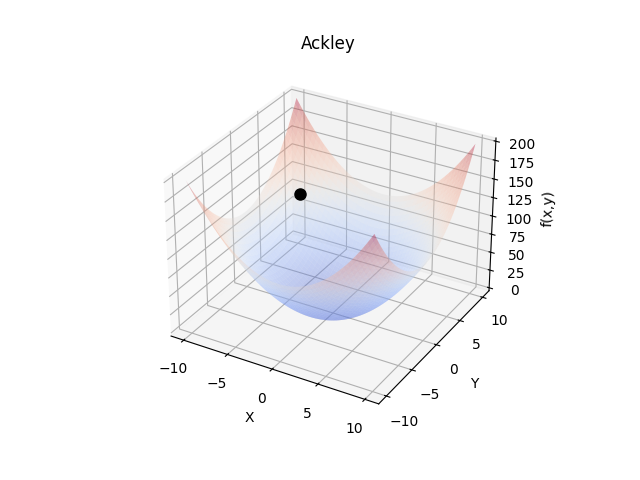

In [94]:

f_sphere =  Function("Sphere")

x = np.linspace(-10, 10, 200)   # body na ose X
y = np.linspace(-10, 10, 200)   # body na ose Y

points = np.array([[i, j] for i in x for j in y])

Z = np.array([f_sphere.sphere(p) for p in points])

Z = Z.reshape(len(y), len(x))

X, Y = np.meshgrid(x, y)

best, history = simulated_annealing(f_ackley.sphere, 2, -10, 10, 100, 0.3, 0.99, sigma=0.2)
ani = animation(X, Y, Z, f_ackley.name, history, repeat=False, interval_ms=50)

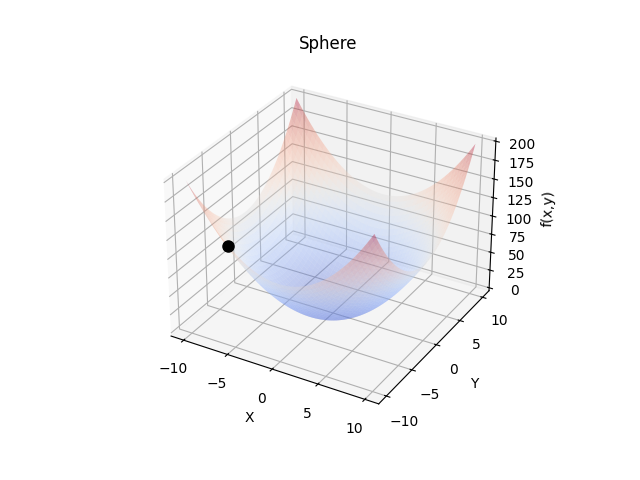

In [97]:
f_sphere2 =  Function("Sphere")

x = np.linspace(-10, 10, 200)   # body na ose X
y = np.linspace(-10, 10, 200)   # body na ose Y

points = np.array([[i, j] for i in x for j in y])

Z = np.array([f_sphere2.sphere(p) for p in points])

Z = Z.reshape(len(y), len(x))

X, Y = np.meshgrid(x, y)

best, history = simulated_annealing(f_sphere2.sphere, 2, -10, 10, 100, 0.3, 0.99, sigma=0.2)
ani = animation(X, Y, Z, f_sphere2.name, history, repeat=False, interval_ms=50)

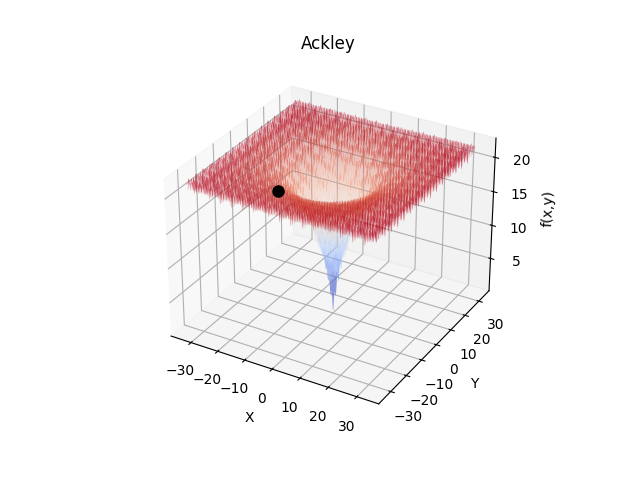

In [100]:
f_ackley =  Function("Ackley")

x = np.linspace(-32.768, 32.768, 500)   # body na ose X
y = np.linspace(-32.768, 32.768, 500)   # body na ose Y

points = np.array([[i, j] for i in x for j in y])

Z = np.array([f_ackley.ackley(p) for p in points])

Z = Z.reshape(len(y), len(x))

X, Y = np.meshgrid(x, y)

best, history = simulated_annealing(f_ackley.ackley, 2, -32.768, 32.768, 100, 0.3, 0.99, sigma=1)
ani = animation(X, Y, Z, f_ackley.name, history, repeat=False, interval_ms=50)

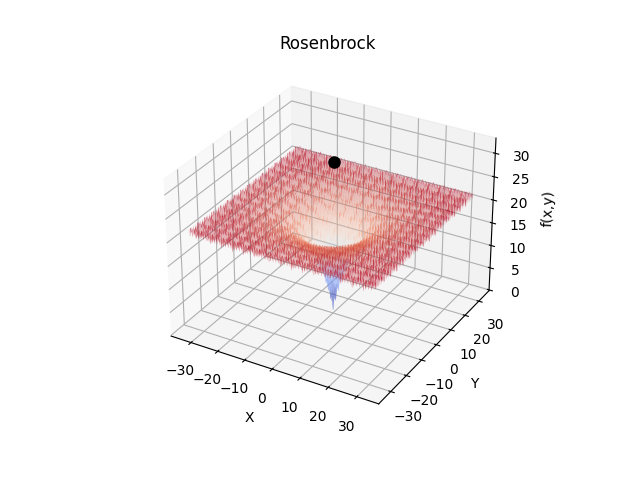

In [101]:
f_rosenbrock =  Function("Rosenbrock")

#x = np.linspace(-2.048, 2.048, 500)
#y = np.linspace(-2.048, 2.048, 500)

x = np.linspace(-10, 10, 500)
y = np.linspace(-5, 5, 500)

points = np.array([[i, j] for i in x for j in y])

Z_rosenbrock = np.array([f_rosenbrock.rosenbrock(p) for p in points])

Z_rosenbrock = Z_rosenbrock.reshape(len(y), len(x))

X_rosenbrock, Y_rosenbrock = np.meshgrid(x, y)

best, history = simulated_annealing(f_rosenbrock.rosenbrock, 2, -5.12, 5.12, 100, 0.3, 0.99, sigma=0.2)
ani = animation(X, Y, Z, f_rosenbrock.name, history, repeat=False, interval_ms=50)